In [1]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import numpy as np
import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

## Read in files

In [3]:
ca_state = gp.read_file("data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("data/CA_Counties_TIGER2016.shp")
ca_bg = gp.read_file("data/tl_2022_06_bg.shp")

In [4]:
# Load census block group level data from EJscreen
# Source: https://www.epa.gov/ejscreen/download-ejscreen-data
# This is the 2017-2021 5-year ACS average data
ejscreen = pd.read_excel("data/CA_EJSCREEN_2022_Full_with_AS_CNMI_GU_VI.xlsx", index_col=None, header=0)

In [5]:
# CA social vulnerability data at level of census tract
# source: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
# calenv4_df = gp.read_file("data/CES4 Final Shapefile.shp")
# calenv4_df['Tract'] = calenv4_df['Tract'].astype(np.int64)  # change from float to int

In [6]:
# read in cleaned and combined flares data
all_flares = gp.read_file("data/all_flares.shp")

In [7]:
# set common crs for project
projcrs = 4326
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)
ca_bg = ca_bg.to_crs(projcrs)

In [8]:
ca_bg.rename(columns={'GEOID':'ID'}, inplace=True)  # match column names for merging
ca_bg['ID'] = ca_bg['ID'].astype(np.int64)

In [9]:
print(f"{len(ejscreen['ID'])} block groups in the EJScreen data \n")
print(f"{len(ca_bg['ID'])} block groups in the CA block group shapefile\n")
ca_bg_joined = pd.merge(ca_bg, ejscreen, on='ID')
print(f"{len(ca_bg['ID'].unique())-len(ca_bg_joined)} block groups are missing after merge")

25607 block groups in the EJScreen data 

25607 block groups in the CA block group shapefile

0 block groups are missing after merge


## Subset flares df to just CA

In [10]:
ca_flares = gp.sjoin(all_flares, ca_counties, how = "inner", predicate = 'within')
print(f'Flares found: {len(ca_flares)}')
ca_flares.drop('index_right', axis=1, inplace=True)

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# add new column for average BCM across all years
ca_flares['BCM_avg'] = ca_flares[col_list].mean(axis=1)  

Flares found: 117


#### Subset BG polygons to only those containing flares

In [11]:
ca_polys_subset = gp.sjoin(ca_bg_joined, ca_flares, how='inner', predicate='contains')

## Regression (in progress)

#### Change to CRS in meters

In [12]:
# epsg3310: https://epsg.io/3310-1739
# units: meters
ca_polys_subset = ca_polys_subset.to_crs(epsg=3310)
ca_flares = ca_flares.to_crs(epsg=3310)
ca_bg_joined = ca_bg_joined.to_crs(epsg=3310)

#### Create new col: distance between BG centroid and nearest flare

In [13]:
# calculate distance between each centroid and nearest flare
ca_bg_joined['dist_flare'] = ca_bg_joined.geometry.centroid.apply(lambda x: ca_flares.distance(x).min())

In [14]:
# Create "flares present" binary dependent variable
ca_bg_joined = ca_bg_joined.assign(flares_present=ca_bg_joined['geometry'].isin(ca_polys_subset['geometry']).astype(int))

In [15]:
print(f"Block groups containing flares (0=no, 1=yes):\n")
print(ca_bg_joined['flares_present'].value_counts())

Block groups containing flares (0=no, 1=yes):

0    25570
1       37
Name: flares_present, dtype: int64


#### Subset data to only what's needed for model

In [16]:
allcols=['D_PM25_2', 'dist_flare', 'flares_present']
for_model = ca_bg_joined[allcols].dropna()  # drop na for now

cols=['D_PM25_2', 'dist_flare']
x=for_model[cols]
y=for_model['flares_present']

#### Implement model

In [30]:
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.007447
         Iterations 15
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.317     
Dependent Variable: flares_present   AIC:              385.1562  
Date:               2023-01-05 08:53 BIC:              401.4561  
No. Observations:   25590            Log-Likelihood:   -190.58   
Df Model:           1                LL-Null:          -278.92   
Df Residuals:       25588            LLR p-value:      2.5735e-40
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     15.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
D_PM25_2     -0.0371    0.0057   -6.4535  0.0000  -0.0483  -0.0258
dist_flare   -0.0006    0.0001  -11.4646  0.0000  -0.0007  -0

#### Fit model

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [19]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[5111    0]
 [   7    0]]


Text(0.5, 427.9555555555555, 'Predicted label')

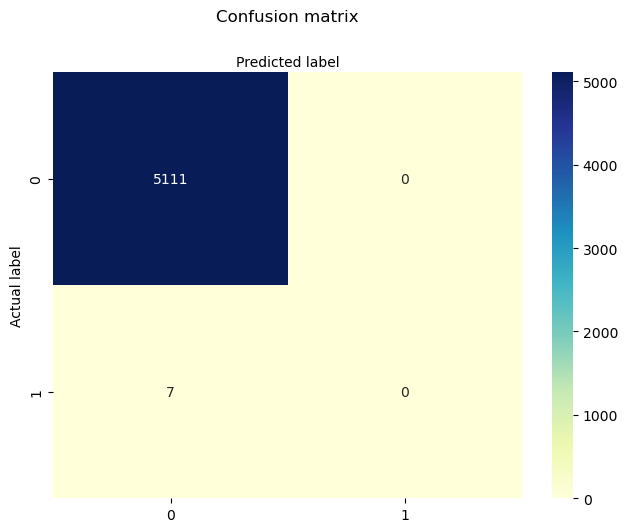

In [21]:
# import required modules
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Text(0.5,257.44,'Predicted label');

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5111
           1       0.00      0.00      0.00         7

    accuracy                           1.00      5118
   macro avg       0.50      0.50      0.50      5118
weighted avg       1.00      1.00      1.00      5118



/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  